<a href="https://colab.research.google.com/github/sling1678/ML_programs_for_video_lectures/blob/main/subset_selection_linear_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustration of Subset Selection and Forward Step Selection strategies for dimensional reduction

We will use the prostate cancer data referred to in the Elements of Statistical Learning (ESL). The data has eight-dimensional predictor

x_1 = log of cancer volume (lcavol); NUMERICAL

x_2 = log of prostate weight (lweight); NUMERICAL

x_3 = age (age); NUMERICAL

x_4 = log of amount of benign prostatic hyperplasia (lbph); NUMERICAL

x_5 = seminal vesicle invasion (svi); INTEGER_CATEGORICAL

x_6 = log of capsular penetration (lcp); NUMERICAL

x_7 = Gleason score (gleason); INTEGER_CATEGORICAL

x_8 = percent of Gleason scores 4 or 5 (pgg45). NUMERICAL

Fig. 3.5 in ESL shows that 3 or 4 captures most of the predictive power as judged by residual sum of squares.

## Subset Selection is an important step. You have to be careful in choosing the metric that is more likely to give a reliable importance of each variable added. The present data is well-suited for linear regression and so, Redual of Sum-of-Squares is appropriate here.

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import itertools

from sklearn import linear_model # This will save time
from sklearn.metrics import mean_squared_error
#-----------------

# Get Data

In [2]:
# Dataframe for this project
DATA_URL = "https://hastie.su.domains/ElemStatLearn/datasets/prostate.data"
df = pd.read_csv(DATA_URL, sep='\t') 

TARGET = ['lpsa']
ALL_FEATURES = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
TRAINING_SET_SELECTION = ['train']
df = df[ALL_FEATURES + TARGET + TRAINING_SET_SELECTION] # drops fictitious columns
df.head(3)# check

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T


In [3]:
# Remove extra columns in the data 
def clean_df(df, dropcols=None):
  if dropcols is not None:
    for col in dropcols:
      if col in df.columns:
        df.drop(col, axis=1, inplace=True)
  return df  

def prepare_train_and_test_sets(df):
  # special for this dataset; datapoints to be used in training
  # are labeled in a separate calumn with letter 'T'
  train_col_name, train_value="train","T"
  train = df[df[train_col_name]==train_value].copy()
  train.drop(columns=[train_col_name], axis=1, inplace=True)
  train.reset_index(drop=True, inplace=True)

  test = df[df[train_col_name]!=train_value].copy()
  test.drop(columns=[train_col_name], axis=1, inplace=True)
  test.reset_index(drop=True, inplace=True)
  return train, test
#-------------------------------------------------------
train, test = prepare_train_and_test_sets(df)

print(f"full dataframe shape:{df.shape}")
print(f"train dataframe shape:{train.shape}")
print(f"test dataframe shape:{test.shape}")
print(f"train dataframe first two rows:\n{train.head(2)}")

full dataframe shape:(97, 10)
train dataframe shape:(67, 9)
test dataframe shape:(30, 9)
train dataframe first two rows:
     lcavol   lweight  age      lbph  svi       lcp  gleason  pgg45      lpsa
0 -0.579818  2.769459   50 -1.386294    0 -1.386294        6      0 -0.430783
1 -0.994252  3.319626   58 -1.386294    0 -1.386294        6      0 -0.162519


In [4]:
# Preprocessing- here only normalizing the train and test datasets based on train
def preprocess_params(train, features):
  means = train[features].mean()
  stds = train[features].std()
  return means, stds
def preprocess(train, test, features):
  means, stds = preprocess_params(train, features)
  train[features] = (train[features]-means)/stds
  test[features] = (test[features]-means)/stds
  return train, test
#-------------------------------------------------------
train, test = preprocess(train, test, features=ALL_FEATURES)
print(train.describe()) # check that mean and std are properly normalized

             lcavol       lweight           age          lbph           svi  \
count  6.700000e+01  6.700000e+01  6.700000e+01  6.700000e+01  6.700000e+01   
mean   2.319869e-17  9.213194e-16 -8.268676e-16  2.651279e-17 -1.325639e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.141144e+00 -2.625262e+00 -3.165237e+00 -9.959549e-01 -5.330630e-01   
25%   -6.641068e-01 -6.205365e-01 -4.993555e-01 -9.959549e-01 -5.330630e-01   
50%    1.242427e-01 -5.754646e-02  3.382089e-02 -8.385392e-02 -5.330630e-01   
75%    8.333990e-01  5.402893e-01  5.669972e-01  1.008480e+00 -5.330630e-01   
max    2.017972e+00  2.421891e+00  1.899938e+00  1.540569e+00  1.847952e+00   

                lcp       gleason         pgg45       lpsa  
count  6.700000e+01  6.700000e+01  6.700000e+01  67.000000  
mean  -3.314099e-18  5.120282e-16 -1.325639e-17   2.452345  
std    1.000000e+00  1.000000e+00  1.000000e+00   1.207812  
min   -8.367687e-01 -1.031712e+00 -8.964872e

## Best Subset Algorithm for dim(x)= p:

1. Produce all $2^p$ subsets. For p=8, we expect 256 subsets. This can be done dynamically by looping using itertools.combinations()

2. Train a linear model on each subset; we will use sklearn-provided linear_model - no need to reinvent the wheel.

3. Store residual sum of square in a default_dict with key= subset_size and value as list. We do that so that it will be easy to get minimum RSS for that subset_size. This step and step 2 can be combined into one function train_and_evaluate_model().

4. Report the results and also plot RSS versus subset_size.

In [5]:
def train_and_evaluate_model(X,y):
  """
  Fit linear regression model and return RSS. 
  """
  model = linear_model.LinearRegression(fit_intercept = True)
  model.fit(X,y)
  RSS = mean_squared_error(y, model.predict(X)) * len(y)
  return RSS


def do_best_subset_selection(df, target):
  results = []
  y = df[target]
  X = df.drop(target, axis=1)
  # for k=0, the empty set, we predict the mean
  predicted_y = np.mean(y.values)
  results.append([ (np.sum(np.square(y.values-predicted_y)),('None',) ) ])
  for subset_size in range(1, len(X.columns)+1,1):
    temp_results=[]
    for subset in itertools.combinations(X.columns, subset_size):
      RSS = train_and_evaluate_model(X[list(subset)],y)
      temp_results.append( (RSS, subset) )
    results.append(temp_results)
  return results 

#-----------------
results = do_best_subset_selection(train, TARGET)


In [6]:
def separate_RSS_and_features(results):
  RSS = []
  features_list=[]
  for k in range(len(results)):
    temp_rss=[]
    temp_features_list=[]
    for r,features in results[k]:
      temp_rss.append(r)
      temp_features_list.append(features)

    RSS.append(np.array(temp_rss))
    features_list.append(temp_features_list)

  return RSS, features_list

def get_best_features_for_each_k(results):
  RSS, features_list = separate_RSS_and_features(results)
  best_features = []
  for i,rs in enumerate(RSS):
    rmin = np.min(rs)
    idx =  np.where(rs == rmin)[0]
    feature_tuple_for_this_k = features_list[i]
    best_features.append( feature_tuple_for_this_k[int(idx)] )
  best_features_for_each_k = dict()
  for i in range(len(best_features)):
    best_features_for_each_k[i] = best_features[i]
  return best_features_for_each_k
  
def process_results(results, verbose=0): 
  RSS, features_list = separate_RSS_and_features(results)
  best_features_for_each_k = get_best_features_for_each_k(results)
  if verbose != 0:
    for k,f in best_features_for_each_k.items():
      print(f"for k = {k}, best features are {f}")
  return RSS, features_list, best_features_for_each_k

_, _, _ = process_results(results, verbose=1)

for k = 0, best features are ('None',)
for k = 1, best features are ('lcavol',)
for k = 2, best features are ('lcavol', 'lweight')
for k = 3, best features are ('lcavol', 'lweight', 'svi')
for k = 4, best features are ('lcavol', 'lweight', 'lbph', 'svi')
for k = 5, best features are ('lcavol', 'lweight', 'lbph', 'svi', 'pgg45')
for k = 6, best features are ('lcavol', 'lweight', 'lbph', 'svi', 'lcp', 'pgg45')
for k = 7, best features are ('lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45')
for k = 8, best features are ('lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45')


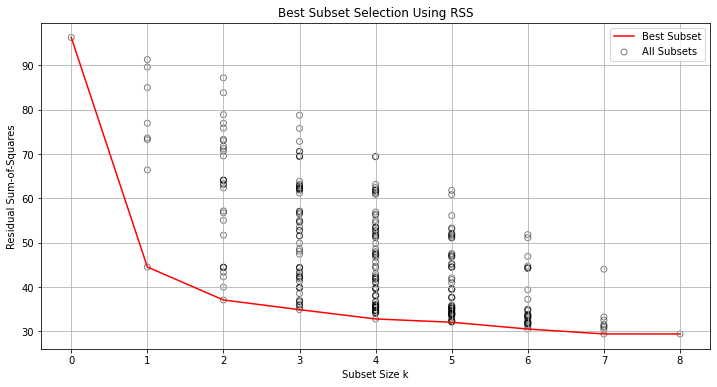

In [7]:
def plot_results(results):
  RSS, features_list = separate_RSS_and_features(results)
  RSS_mins = [np.min(x) for x in RSS]
  x1 = []
  y1 = []
  for i,dat in enumerate(RSS):
    L = len(dat)
    for k in range(L):
      x1.append(i)
    for r in dat:
      y1.append(r)
  x1 = np.array(x1)
  y1 = np.array(y1)

  x2 = np.array(range(len(RSS_mins)))
  y2 = RSS_mins
  
  fig, ax = plt.subplots(1,1, figsize = (12,6))
  ax.scatter(x1, y1, alpha = .5,  facecolors='none', edgecolors='k', label='All Subsets')
  ax.set_xlabel('Subset Size k')
  ax.set_ylabel('Residual Sum-of-Squares')
  ax.set_title('Best Subset Selection Using RSS')

  ax.plot(x2, y2, color = 'r', label = 'Best Subset')
  ax.legend()
  plt.grid(True)

#--------------
plot_results(results)

#^^ In the above, the error measure to distinguish various subsets was evaluated ON THE SAME DATA THAT WAS USED TO FIT THE LINEAR MODEL. That underestimates the generalization error. 

An appropriate way to handle this situation will be to split the training data into two parts: one to fit the data and the other to evaluate the fitted model. This is best done by Cross Validation and/or Bootstrap. I will tackle them in another notebook. 

#Forward-Stepwise Selection

The drawback of Subset Selection method given above is that you need to run model on all $2^p$ subsets. When $p$ becomes large, the number of subsets grows rapidly and soon the computation becomes infeasible. A greedy algorithm that starts with no features and adds one feature by selecting which unused feature improves the performance most. For instant, if we have added $k$ features and there remain $p-k$ features. You add one feature at a time from the remaining $p-k$ features to make $p-k$ sets of size $k+1$ and then you keep the best among them. This recursion will stop when all $p$ features have been explored.

In [8]:
def do_forward_stepwise_selection(df, target):
  results = []
  y = df[target]
  X = df.drop(target, axis=1)
  # for k=0, the empty set, we predict the mean
  predicted_y = np.mean(y.values)
  RSS_none = np.sum(np.square(y.values-predicted_y))
  features_done=('None',)
  results.append( (RSS_none, tuple(features_done)) )
  features_done = []
  features_to_explore = list(X.columns) #OK

  while len(features_to_explore) != 0:

    temp_results = []
    temp_features = []
    for idx in range(len(features_to_explore)):
      new_feature_to_try = np.random.choice(features_to_explore)
      if features_done is not None:
        features_trying = features_done + [new_feature_to_try]
      else:
        features_trying = [new_feature_to_try]
      RSS = train_and_evaluate_model(X[list(features_trying)],y)
 
      temp_results.append(RSS)
      temp_features.append(new_feature_to_try)
    
    min_RSS = min(temp_results)
    min_index = temp_results.index(min_RSS)
    feature_to_add = temp_features[min_index]

    features_to_explore.remove(feature_to_add)
    if features_done is not None:
      features_done = features_done + [feature_to_add]
    else:
      features_done = [feature_to_add]
 
    results_package = (min_RSS, tuple(features_done))   
    results.append(results_package) 

  return results

def process_results_forward_stepwise(results, verbose=1):
  """
  Set verbose = 0 to stop printout.
  """
  RSS_list=[]
  features_list=[]
  for item in results:
    RSS_list.append(item[0])
    features_list.append(item[1])

  if verbose!=0:
    for k,features in enumerate(features_list):
      print(f"for k = {k}, the best features by forward procedure are {features}")
  
  return RSS_list, features_list
 

#------------------
if False:
  %timeit results = do_best_subset_selection(train, TARGET)
  %timeit results = do_forward_stepwise_selection(train, TARGET)

print("Best Subset Selection Algorithm Results:")
results = do_best_subset_selection(train, TARGET)
_, _, _ = process_results(results, verbose=1)
print("\nForward-Stepwise Selection Algorithm Results:")
results = do_forward_stepwise_selection(train, TARGET)
_, _ = process_results_forward_stepwise(results)
 

Best Subset Selection Algorithm Results:
for k = 0, best features are ('None',)
for k = 1, best features are ('lcavol',)
for k = 2, best features are ('lcavol', 'lweight')
for k = 3, best features are ('lcavol', 'lweight', 'svi')
for k = 4, best features are ('lcavol', 'lweight', 'lbph', 'svi')
for k = 5, best features are ('lcavol', 'lweight', 'lbph', 'svi', 'pgg45')
for k = 6, best features are ('lcavol', 'lweight', 'lbph', 'svi', 'lcp', 'pgg45')
for k = 7, best features are ('lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45')
for k = 8, best features are ('lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45')

Forward-Stepwise Selection Algorithm Results:
for k = 0, the best features by forward procedure are ('None',)
for k = 1, the best features by forward procedure are ('lcavol',)
for k = 2, the best features by forward procedure are ('lcavol', 'lbph')
for k = 3, the best features by forward procedure are ('lcavol', 'lbph', 'pgg45')
for k = 4, the best featur

## Forward-Stepwise has a randomness due to randomly picking from the remaining variables. We can run this routine several times and maybe do a plurality voting for each k from different runs to choose the most likely first, second, third, etc. I am not going to do this additional experiment.